# **Refocus**: Host<->Network Append instead of Merge
------------------

1. Host<->Network Append (done)
2. Common Timestamp Column (done)
3. Appy Network TP_Binary based on Source_IP, Dest_IP, Dest_Port (done)
4. Apply Time Window Broad Label - TWB_Binary
5. Apply Time Window Micro Label - TWM_Binary
6. Apply Threat Hunter Expanded Label - THE_Binary

### Import Libraries

In [1]:
import pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model.logistic import LogisticRegression
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 500

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load Network Data

In [2]:
df_zeek = pd.read_json("combined_zeek.log", lines = True)
df_zeek.replace('nan', np.nan, inplace=True)
print(type(df_zeek))
print(df_zeek.shape)
#print(df_zeek.EventID.value_counts())
df_zeek.head()

<class 'pandas.core.frame.DataFrame'>
(2140, 148)


,@stream,@system,@proc,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,orig_l2_addr,resp_l2_addr,rtt,named_pipe,endpoint,operation,trans_id,query,qclass,qclass_name,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected,analyzer,failure_reason,fuid,tx_hosts,rx_hosts,conn_uids,source,depth,analyzers,mime_type,filename,is_orig,seen_bytes,total_bytes,missing_bytes,overflow_bytes,timedout,md5,sha1,request_type,client,success,error_msg,till,forwardable,renewable,cipher,note,msg,sub,src,dst,p,actions,suppress_for,action,path,name,size,times_modified,times_accessed,times_created,times_changed,share_type,version,curve,server_name,resumed,established,cert_chain_fuids,client_cert_chain_fuids,subject,issuer,validation_status,resp_certificate_sha1,ja3,ja3s,notice,peer,addl,id,certificate_version,certificate_serial,certificate_subject,certificate_issuer,certificate_not_valid_before,certificate_not_valid_after,certificate_key_alg,certificate_sig_alg,certificate_key_type,certificate_key_length,certificate_exponent,basic_constraints_ca,extracted,extracted_cutoff,trans_depth,method,host,uri,user_agent,request_body_len,response_body_len,status_code,status_msg,tags,resp_fuids,resp_mime_types,client_header_names,orig_fuids,orig_mime_types,machine,compile_ts,os,subsystem,is_exe,is_64bit,uses_aslr,uses_dep,uses_code_integrity,uses_seh,has_import_table,has_export_table,has_cert_table,has_debug_data,section_names
0,conn,bobs.bigwheel.local,zeek,1.588205e+09,Cvf4XX17hSAgXDdGEd,10.0.1.6,54243.0,10.0.0.4,53.0,udp,dns,0.001528,39.0,55.0,SF,0.0,Dd,1.0,67.0,1.0,83.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,conn,bobs.bigwheel.local,zeek,1.588205e+09,CJ21Le4zsTUcyKKi98,10.0.1.6,56880.0,10.0.0.4,445.0,tcp,"gssapi,smb,krb",10.761077,4020.0,1681.0,RSTO,0.0,ShADdaR,12.0,1307.0,11.0,2133.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,conn,bobs.bigwheel.local,zeek,1.588205e+09,CnOP7t1eGGHf6LFfuk,10.0.1.6,65108.0,10.0.0.4,53.0,udp,dns,0.001599,36.0,104.0,SF,0.0,Dd,1.0,64.0,1.0,132.0,00:0d:3a:13:e3:69,12:34:56:78:9a:bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,conn,bobs.bigwheel.local,zeek,1.588205e+09,CvxbPE3MuO7boUdSc8,10.0.1.6,138.0,10.0.1.255,138.0,udp,NaN,NaN,NaN,NaN,S0,0.0,D,1.0,229.0,0.0,0.0,00:0d:3a:13:e3:69,ff:ff:ff:ff:ff:ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Load Host Data

In [3]:
df_label = pd.read_json('./df_labelled_coalesce.json', lines=True)
df_label['TP_Binary'] = df_label.TP_Label!='0'
df_label.replace('-', np.nan, inplace=True)
print(type(df_label))
print(df_label.shape)
print(df_label.EventID.value_counts())
df_label.head(1)

<class 'pandas.core.frame.DataFrame'>
(198760, 390)
12       61158
10       39286
7        20259
13       17542
4658     10973
         ...  
172          1
46           1
50103        1
306          1
41           1
Name: EventID, Length: 165, dtype: int64


,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,

## Host<->Network Append
------------------

In [4]:
# Replace the below merge with a append
# Join Host<->Network based on 
#df_label = pd.merge(
#    left = df_label,
#    right = df_zeek,
#    how = 'outer',
#    on = ['@timestamp', 'EventID']
#)

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
#    In [9]: result = pd.concat([df1, df4], axis=1, sort=False)
df_label = df_label.append(df_zeek, ignore_index=True, sort=False)

In [6]:
df_label.shape

(200900, 536)

In [7]:
df_label.head(1)

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,...,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSourceMapped,ModifyingApplication,ModifyingUser,Origin,Profiles,RemoteAddresses,RuleStatus,SchemaVersion,SecurityOptions,CountNew,CountOld,EnabledNew,UpdateReason,NewTime,PreviousTime,NotificationPackageName,ShutdownActionType,ShutdownEventCode,ShutdownReason,BootMode,BuildVersion,MajorVersion,MinorVersion,QfeVersion,ServiceVersion,StartTime,EnableDisableReason,VsmPolicy,DCName,ProcessingMode,ProcessingTimeInMilliseconds,SupportInfo1,SupportInfo2,Gr

In [8]:
df_label.tail(1)

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,...,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSourceMapped,ModifyingApplication,ModifyingUser,Origin,Profiles,RemoteAddresses,RuleStatus,SchemaVersion,SecurityOptions,CountNew,CountOld,EnabledNew,UpdateReason,NewTime,PreviousTime,NotificationPackageName,ShutdownActionType,ShutdownEventCode,ShutdownReason,BootMode,BuildVersion,MajorVersion,MinorVersion,QfeVersion,ServiceVersion,StartTime,EnableDisableReason,VsmPolicy,DCName,ProcessingMode,ProcessingTimeInMilliseconds,SupportInfo1,SupportInfo2,Gr

# Normalize Timestamp, IP/Port Columns
------------------

## Common Timestamp Column

In [9]:
df_label['time_stamp'] = df_label['@timestamp'].apply(lambda x: (pd.Timestamp(x)))

In [10]:
df_label['time_stamp'] = df_label['time_stamp'].fillna(df_label['ts'].apply(lambda x: (pd.to_datetime(x, unit='s', utc=True))))

### Old Timestamp Approach... Suboptimal

## Common IP/Port Columns

In [11]:
# Transform Host Data - Similar Data to Single Columns
df_label['Destination_IP'] = df_label['DestinationIp']
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['DestAddress'])
df_label['Source_IP'] = df_label['IpAddress']
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceIp'])
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['SourceAddress'])
df_label['Source_Port'] = df_label['IpPort']
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['SourcePort'])
df_label['Destination_Port'] = df_label['DestinationPort']
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['DestPort'])

In [12]:
# Transform Network Data - Similar Data to Single Columns
df_label['Source_IP'] = df_label['Source_IP'].fillna(df_label['id_orig_h'])
df_label['Source_Port'] = df_label['Source_Port'].fillna(df_label['id_orig_p'])
df_label['Destination_IP'] = df_label['Destination_IP'].fillna(df_label['id_resp_h'])
df_label['Destination_Port'] = df_label['Destination_Port'].fillna(df_label['id_resp_p'])

## Common Hostname/uid Column

In [13]:
df_label['Hostname_uid'] = df_label['Hostname']

In [14]:
df_label['Hostname_uid'] = df_label['Hostname_uid'].fillna(df_label['uid'])

# Appy Labelling Approaches
------------------

## Appy Network TP_Binary based on Source_IP, Dest_IP, Dest_Port

In [15]:
# Check for NaN Entries. There should be some. More Source than Dest. All network related records should have at least Source data.
df_label['Source_IP'].notna().value_counts()

False    192516
True       8384
Name: Source_IP, dtype: int64

In [16]:
# Check for NaN Entries. There should be some.
df_label['Destination_IP'].notna().value_counts()

False    195164
True       5736
Name: Destination_IP, dtype: int64

### ID Bad Flows from TP_Binary

In [17]:
# bad_flows = df.loc[(df['TP_Binary'] == True) & (df[colName].notnull())]['ProcessGuid'].unique()
df_label[(df_label.TP_Binary==True) & (df_label.Source_IP.notnull()) & (df_label.Destination_IP.notnull())][['EventID', 'TP_Binary', 'TP_Label', 'time_stamp', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port']].drop_duplicates()

,EventID,TP_Binary,TP_Label,time_stamp,Source_IP,Source_Port,Destination_IP,Destination_Port
12637,5156.0,True,"0, 8.A.2. Remote System Discovery",2020-05-02 03:09:29.935000+00:00,10.0.1.4,59961,10.0.1.6,5985.0
14743,3.0,True,"0, 8.A.1. Remote System Discovery",2020-05-02 03:09:07.649000+00:00,10.0.1.4,59955,10.0.0.4,389.0
16280,5156.0,True,"0, 3.B.3. Commonly Used Port",2020-05-02 02:58:47.195000+00:00,10.0.1.4,59845,192.168.0.5,443.0
24641,3.0,True,"0, 8.A.2. Remote System Discovery",2020-05-02 03:09:31.065000+00:00,10.0.1.4,59960,10.0.1.6,5985.0
29064,5156.0,True,"0, 8.A.1. Remote System Discovery",2020-05-02 03:09:05.633000+00:00,10.0.1.4,59955,10.0.0.4,389.0
29065,5156.0,True,"0, 8.A.2. Remote System Discovery",2020-05-02 03:09:32.125000+00:00,10.0.1.4,59962,10.0.1.6,5985.0
49253,3.0,True,"0, 8.A.2. Remote System Discovery",2020-05-02 03:09:33.128000+00:00,10.0.1.4,59962,10.0.1.6,5985.0
53904,5156.0,True,"0, 8.A.1. Remote System Discovery",2020-05-02 03:09:05.635000+00:00,10.0.1.4,59957,10.0.0.4,389.0
62937,3.0,True,"0, 3.B.3. Commonly Used Port",2020-05-02 02:58:48.298000+00:00,10.0.1.4,59845,192.168.0.5,443.0
74758,3.0,True,"0, 8.A.1. Remote System Discovery",2020-05-02 03:09:07.650000+00:00,10.0.1.4,59957,10.0.0.4,389.0


In [18]:
df_label[(df_label.TP_Binary==True) & (df_label.Source_IP.notnull()) & (df_label.Destination_IP.notnull())].groupby(['TP_Label', 'Source_IP', 'Destination_IP', 'Destination_Port'])['time_stamp', 'EventID', 'TP_Binary', 'Source_IP', 'Destination_IP', 'Destination_Port'].count()

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,,,,time_stamp,EventID,TP_Binary,Source_IP,Destination_IP,Destination_Port
TP_Label,Source_IP,Destination_IP,Destination_Port,,,,,,
"0, 1.A.3. Uncommonly Used Port",10.0.1.4,192.168.0.5,1234.0,2,2,2,2,2,2
"0, 3.B.3. Commonly Used Port",10.0.1.4,192.168.0.5,443.0,4,4,4,4,4,4
"0, 8.A.1. Remote System Discovery",10.0.1.4,10.0.0.4,389.0,4,4,4,4,4,4
"0, 8.A.2. Remote System Discovery",10.0.1.4,10.0.1.6,5985.0,8,8,8,8,8,8


### Apply TP_Binary label to bad flows -> using for loop approach.

In [19]:
df_label.TP_Binary.value_counts()

False    195322
True       3438
Name: TP_Binary, dtype: int64

In [20]:
bad_flows = df_label[(df_label.TP_Binary==True) & (df_label.Source_IP.notnull()) & (df_label.Destination_IP.notnull())].groupby(['TP_Label', 'Source_IP', 'Destination_IP', 'Destination_Port'])['time_stamp', 'EventID', 'TP_Binary', 'Source_IP', 'Destination_IP', 'Destination_Port'].count()

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [21]:
for namedTuple in bad_flows.itertuples():
    df_label['TP_Label'].loc[(df_label.id_orig_h == namedTuple.Index[1]) &
                             (df_label.id_resp_h == namedTuple.Index[2]) &
                             (df_label.id_resp_p == namedTuple.Index[3])] = namedTuple.Index[0]
    print(df_label['TP_Label'].count())

198761
198766
198778
198786


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
df_label['TP_Label'] = df_label.TP_Label.fillna('0')

In [23]:
df_label['TP_Binary'] = df_label.TP_Label!='0'

In [24]:
# Check the host data TP_Binary distribution
df_label['TP_Binary'].loc[df_label.EventID.notna()].value_counts()

False    195322
True       3438
Name: TP_Binary, dtype: int64

In [25]:
# Check the network data TP_Binary distribution
df_label['TP_Binary'].loc[df_label['@system'].notna()].value_counts()

False    2114
True       26
Name: TP_Binary, dtype: int64

In [26]:
# Re-Check with TP_Binary and TP_Label
#     -> Fixed. Notice the difference between EventID count and id_orig_h count. 
#     -> Shows Host and zeek TP_Label->TP_Binary are both making the correct transformation.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_label.groupby(['TP_Binary', 'TP_Label'])['EventID', 'id_orig_h', 'TP_Binary', 'Source_IP', 'Destination_IP', 'Destination_Port'].count())

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


EventID  \
TP_Binary TP_Label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
False     0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      195322   
True      0, 1.A.1. User Execution                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1   
          0, 1.A.1. User Execution, 1.A.2. Masquerading                                                                                                                                                                                                                                                                                                                                                                                                                                                                               2   
          0, 1.A.3. Uncommonly Used Port                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2   
          0, 1.A.4. Standard Cryptographic Protocol                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   1   
          0, 1.B.1. Command-Line Interface                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            3   
          0, 1.B.1. Command-Line Interface, 2.A.1. File and Directory Discovery                                                                                                                                                                                                                                                         

## Apply Time Window Broad Label - TWB_Binary
------------------

### Apply Time Window Broad to Host Events

In [27]:
# Only Showing Host data for Hostname hits.
#    -> Need Common Hostname or System or Source_IP or something
#        -> landed on uid for network data
df_label.loc[df_label.TP_Binary == True].sort_values('time_stamp').groupby(['TP_Binary', 'Hostname'])['time_stamp'].agg(['first','last', 'count'])

first  \
TP_Binary Hostname                                                  
True      NASHUA.dmevals.local   2020-05-02 03:09:29.929000+00:00   
          NEWYORK.dmevals.local  2020-05-02 03:04:05.749000+00:00   
          SCRANTON.dmevals.local 2020-05-02 02:55:57.730000+00:00   

                                                             last  count  
TP_Binary Hostname                                                        
True      NASHUA.dmevals.local   2020-05-02 03:17:53.817000+00:00     44  
          NEWYORK.dmevals.local  2020-05-02 03:04:05.749000+00:00      1  
          SCRANTON.dmevals.local 2020-05-02 03:19:53.189000+00:00   3393

In [28]:
bad_broad_timewindows = df_label.loc[df_label.TP_Binary == True].sort_values('time_stamp').groupby(['TP_Binary', 'Hostname'])['time_stamp'].agg(['first','last', 'count'])

In [29]:
df_label['TWB_Binary'] = False

In [30]:
df_label['TWB_Binary'].value_counts()

False    200900
Name: TWB_Binary, dtype: int64

In [31]:
for namedTuple in bad_broad_timewindows.itertuples():
    #print(namedTuple.first)
    #print(namedTuple.last)
    #print(namedTuple.Index[1])
    #df_label['TWB_Binary'].loc[(df_label['time_stamp'] >= namedTuple.first) & 
    #                       (df_label['time_stamp'] <= namedTuple.last) &
    #                       ((df_label['Source_IP'] == namedTuple.Index[1]) & (df_label['Destination_IP'] == namedTuple.Index[2]) |
    #                        (df_label['Source_IP'] == namedTuple.Index[2]) & (df_label['Destination_IP'] == namedTuple.Index[1]))
    #                      ] = True
    # Label malicious: start<>end time and hostname
    df_label['TWB_Binary'].loc[(df_label['time_stamp'] >= namedTuple.first) & 
                               (df_label['time_stamp'] <= namedTuple.last) &
                               (df_label['Hostname'] == namedTuple.Index[1])
                              ] = True
    print(df_label['TWB_Binary'].value_counts())

False    189842
True      11058
Name: TWB_Binary, dtype: int64
False    189837
True      11063
Name: TWB_Binary, dtype: int64
False    111336
True      89564
Name: TWB_Binary, dtype: int64


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
# WORKS!

### Apply Time Window Broad to Network Events

In [33]:
# Get First and Last Timestamps for network data.
df_label.loc[(df_label['id_orig_h'].notna())].sort_values('time_stamp').groupby(['TP_Binary', 'Source_IP', 'Destination_IP'])['time_stamp'].agg(['first','last', 'count'])

first  \
TP_Binary Source_IP Destination_IP                                       
False     10.0.1.4  10.0.0.4       2020-04-30 00:06:38.899709940+00:00   
                    10.0.1.255     2020-04-30 00:09:01.189415932+00:00   
                    10.0.1.6       2020-04-30 00:35:25.606390953+00:00   
                    192.168.0.4    2020-04-30 00:32:14.891381979+00:00   
          10.0.1.6  10.0.0.4       2020-04-30 00:06:39.824369907+00:00   
                    10.0.1.255     2020-04-30 00:08:43.385543108+00:00   
                    192.168.0.4    2020-04-30 00:40:44.730953932+00:00   
True      10.0.1.4  10.0.0.4       2020-04-30 00:12:00.847908020+00:00   
                    10.0.1.6       2020-04-30 00:33:26.283442020+00:00   
                    192.168.0.5    2020-04-30 00:08:02.361653090+00:00   

                                                                  last  count  
TP_Binary Source_IP Destination_IP                                             
False     10.0.1.4  10.0.0.4       2020-04-30 00:43:58.389343023+00:00    179  
                    10.0.1.255     2020-04-30 00:45:00.760719061+00:00      8  
                    10.0.1.6       2020-04-30 00:45:00.056051970+00:00    104  
                    192.168.0.4    2020-04-30 00:35:25.658109903+00:00     78  
          10.0.1.6  10.0.0.4       2020-04-30 00:43:59.015400887+00:00    148  
                    10.0.1.255     2020-04-30 00:44:42.662991047+00:00      8  
                    192.168.0.4    2020-04-30 00:44:44.752271891+00:00    753  
True      10.0.1.4  10.0.0.4       2020-04-30 00:35:04.410170078+00:00     12  
                    10.0.1.6       2020-04-30 00:33:29.289120913+00:00      8  
                    192.168.0.5    2020-04-30 00:15:18.751499891+00:00      6

In [34]:
bad_broad_netflows = df_label.loc[((df_label['id_orig_h'].notna()) & df_label.TP_Binary == True)].sort_values('time_stamp').groupby(['TP_Binary', 'Source_IP', 'Destination_IP'])['time_stamp'].agg(['first','last', 'count'])

In [35]:
bad_broad_netflows

first  \
TP_Binary Source_IP Destination_IP                                       
True      10.0.1.4  10.0.0.4       2020-04-30 00:12:00.847908020+00:00   
                    10.0.1.6       2020-04-30 00:33:26.283442020+00:00   
                    192.168.0.5    2020-04-30 00:08:02.361653090+00:00   

                                                                  last  count  
TP_Binary Source_IP Destination_IP                                             
True      10.0.1.4  10.0.0.4       2020-04-30 00:35:04.410170078+00:00     12  
                    10.0.1.6       2020-04-30 00:33:29.289120913+00:00      8  
                    192.168.0.5    2020-04-30 00:15:18.751499891+00:00      6

In [36]:
df_label['TWB_Binary'].value_counts()

False    111336
True      89564
Name: TWB_Binary, dtype: int64

In [37]:
for namedTuple in bad_broad_netflows.itertuples():
    #print(namedTuple.first)
    #print(namedTuple.last)
    #print(namedTuple.Index[1])
    #print(namedTuple.Index[2])
    df_label['TWB_Binary'].loc[(df_label['time_stamp'] >= namedTuple.first) & 
                           (df_label['time_stamp'] <= namedTuple.last) &
                           ((df_label['Source_IP'] == namedTuple.Index[1]) & (df_label['Destination_IP'] == namedTuple.Index[2]) |
                            (df_label['Source_IP'] == namedTuple.Index[2]) & (df_label['Destination_IP'] == namedTuple.Index[1]))
                          ] = True
    print(df_label['TWB_Binary'].value_counts())

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


False    111186
True      89714
Name: TWB_Binary, dtype: int64
False    111178
True      89722
Name: TWB_Binary, dtype: int64
False    111172
True      89728
Name: TWB_Binary, dtype: int64


## Apply Time Window Micro Label - TWM_Binary
------------------

In [38]:
# Maybe start with a unified 'hostname' identifier field.
#    -> Hostname or 'Source_IP + Destination_IP'
#    -> zeek uid might be better => "As a connection is processed by Zeek, a unique identifier is assigned to each session"
# No need! intertuple to the rescue.
df_label['Hostname_uid'].value_counts()

SCRANTON.dmevals.local    133796
NASHUA.dmevals.local       29058
NEWYORK.dmevals.local      23935
UTICA.dmevals.local        11971
CIVc4v3hpPmaYo6fld            44
                           ...  
CUoP9P1S3HfoM7QkZj             1
CSC0rtrsiwUcNkBFj              1
CgShqlDTmsK9nIisk              1
C3gfR92oLE8Ya7wBle             1
CdVi552XqCuoEQr5lb             1
Name: Hostname_uid, Length: 617, dtype: int64

In [39]:
df_label['time_stamp_seconds'] = df_label['time_stamp'].apply(lambda x: (pd.to_datetime(x, unit='s', utc=True).ctime()))

In [40]:
bad_seconds = df_label[df_label.TP_Binary==True][['time_stamp_seconds', 'Hostname', 'uid']].drop_duplicates()

In [41]:
df_label.shape

(200900, 544)

In [42]:
df_label['TWM_Binary'] = False

In [43]:
df_label.shape

(200900, 545)

In [44]:
df_label['TWM_Binary'].value_counts()

False    200900
Name: TWM_Binary, dtype: int64

In [45]:
# This could be way better than merge or the crazy time window copy paste logic.
# SOOO Much faster than the merge. Same result.
for namedTuple in bad_seconds.itertuples(index=False):
    #print(namedTuple)
    df_label['TWM_Binary'].loc[(df_label.time_stamp_seconds == namedTuple.time_stamp_seconds) &
                               ((df_label.Hostname == namedTuple.Hostname) |
                               (df_label.uid == namedTuple.uid))
                              ] = True

In [46]:
df_label['TWM_Binary'].value_counts()

False    181496
True      19404
Name: TWM_Binary, dtype: int64

## Apply Threat Hunter Expanded Label - THE_Binary
------------------
- There is a problem with the TP_Binary label. 
- My implementation of the Threat Hunting approach is so specific that a 'malicious' ProcessGuid could me marked True in a given record but the same ProcessGuid is found in plenty of other records marked False.
- The Threat Hunting approach (in the most abstract) is take alert as entry point into dataset, pivot to discover new 'malicious' selectors, pivot using the new selectors, rinse, repeat (not unlike semi-supervised learning cough cough).
- To fully demonstrate the Threat Hunting approach it is important to exapand the label based on the derived 'malicious' selectors.
- This label will be based on the list of 'malicious' selectors (objects/nodes/etc) - like, processes, files, users, etc.
- This label will be better suited for classical ML scoring (accuracy, precision, f1-score, etc).

In [47]:
df_label['THE_Binary'] = df_label['TP_Binary']

In [48]:
df_label['TP_Binary'].value_counts()

False    197436
True       3464
Name: TP_Binary, dtype: int64

In [49]:
df_label['THE_Binary'].value_counts()

False    197436
True       3464
Name: THE_Binary, dtype: int64

### Bad Files?

In [50]:
# Files is a little tougher. There isn't a GUID for files... So it'll be difficult to differentiate between hosts (easily)
#     -> But ther is an ObjectGUID but it isn't recorded in the Windows Events
#     -> what about the object's sid? Should be unique within the Domain because it contains a specific RID from the DC-RID-master
# Plus Image rolls up a bunch of benign binaries used for malicious purposes on a given host.
df_label.loc[(df_label.TP_Binary == True)].groupby(['Image'])['EventID'].unique()

Image
C:\Program Files\SysinternalsSuite\accessChk.exe                               [7.0]
C:\Program Files\SysinternalsSuite\sdelete64.exe             [13.0, 23.0, 12.0, 1.0]
C:\ProgramData\victim\â€®cod.3aka3.scr                         [11.0, 3.0, 1.0, 7.0]
C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe            [7.0, 3.0, 1.0]
C:\Windows\System32\cmd.exe                                                    [1.0]
C:\Windows\System32\control.exe                                                [1.0]
C:\Windows\System32\javamtsup.exe                                              [1.0]
C:\Windows\System32\rundll32.exe                                               [1.0]
C:\Windows\Temp\Rar.exe                                                        [1.0]
C:\Windows\Temp\python.exe                                               [11.0, 1.0]
C:\Windows\Temp\sdelete64.exe                                                 [23.0]
C:\windows\System32\WindowsPowerShell\v1.0\powershell.exe  

In [51]:
# TargetFilename we can isolate only those files:
# df_label.loc[(df_label.TargetFilename.notna())]['EventID'].unique()
#    Event ID 2: A process changed a file creation time
#    Event ID 11: FileCreate
#    Event ID 15: FileCreateStreamHash
#    Event ID 23: FileDelete (A file delete was detected)
# that carry a TP_Binary == True label. 
# All these events are sysmon generated. Comperable organic Windows events are (Open 4656, Access 4663, Close 4658)
# Notice the ZZZZ.ZZZ files. 
#    -> These are evidence of the defense evasion technique to throw characters into event creation that it can't handle.
#    -> But we can use this fact as a clear marker of 'malicious' behavior.
#df_label.loc[(df_label.TP_Binary == True) & (df_label.TargetFilename.notna())]['TargetFilename'].drop_duplicates()
#df_label[(df_label.TP_Binary==True) & (df_label.TargetFilename.notna())]['TargetFilename'].value_counts()

In [52]:
df_label.loc[(df_label.TP_Binary == True)].groupby(['TargetFilename'])['EventID'].unique()

TargetFilename
C:\ProgramData\Microsoft\Windows\Start Menu\Programs\StartUp\hostui.lnk          [11.0]
C:\Users\pbeesZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ.ZZZ                                 [23.0]
C:\Users\pbeesly\AppData\Roaming\Draft.Zip                                       [11.0]
C:\Users\pbeesly\AppData\Roaming\OfficeSupplies.7z                               [11.0]
C:\Users\pbeesly\AppData\Roaming\working.zip                                     [11.0]
C:\Users\pbeesly\Desktop\working.zip                                             [23.0]
C:\Users\pbeesly\Downloads\coyn5igj.3io.pfx                                      [11.0]
C:\Users\pbeesly\Downloads\monkey.png                                            [11.0]
C:\Users\pbeesly\ZZZZZZZZZZZZZZZZZZZZZ.ZZZ                                       [23.0]
C:\Users\pbeesly\ZZZZZZZZZZZZZZZZZZZZZZZ.ZZZ                                     [23.0]
C:\Windows\Temp\Rar.exe                                                    [11.0, 23.0]
C:\Windows\Temp\p

In [53]:
# TargetFilename and Image could be solid pivot fields.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_label.loc[((df_label['Image'].str.contains("sdelete64.exe")) | 
                          (df_label['CommandLine'].str.contains('sdelete64.exe')) | 
                         (df_label.TargetFilename == 'C:\Windows\Temp\sdelete64.exe'))].groupby(['EventID', 'Image', 'TargetFilename', 'TargetObject', 'ImageLoaded', 'OriginalFileName', 'Hashes', 'CommandLine']).count())

,,,,,,,,@timestamp,@version,Category,Channel,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,IsExecutable,ProcessGuid,User,CreationUtcTime,Company,Description,FileVersion,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSour

In [54]:
df_label[(df_label.TP_Binary==True) & (df_label.TargetFilename.notna())]['TargetFilename'].unique()

array(['C:\\Users\\pbeesly\\Downloads\\monkey.png',
       'C:\\Windows\\Temp\\Rar.exe',
       'C:\\Users\\pbeesly\\ZZZZZZZZZZZZZZZZZZZZZ.ZZZ',
       'C:\\Users\\pbeesZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ.ZZZ',
       'C:\\Windows\\Temp\\sdelete64.exe',
       'C:\\Users\\pbeesly\\Downloads\\coyn5igj.3io.pfx',
       'C:\\Windows\\Temp\\python.exe',
       'C:\\Users\\pbeesly\\ZZZZZZZZZZZZZZZZZZZZZZZ.ZZZ',
       'C:\\Users\\pbeesly\\AppData\\Roaming\\working.zip',
       'C:\\Users\\pbeesly\\Desktop\\working.zip',
       'C:\\Users\\pbeesly\\AppData\\Roaming\\OfficeSupplies.7z',
       'C:\\Users\\pbeesly\\AppData\\Roaming\\Draft.Zip',
       'C:\\ProgramData\\Microsoft\\Windows\\Start Menu\\Programs\\StartUp\\hostui.lnk'],
      dtype=object)

In [55]:
bad_files = df_label[(df_label.TP_Binary==True) & (df_label.TargetFilename.notna())]['TargetFilename'].unique()

In [56]:
# Pivoting on bad files would pick up records outside of TP_Binary
df_label.loc[(df_label.TP_Binary == False) & ((df_label.TargetFilename.isin(bad_files)) |
                                              (df_label.Image.isin(bad_files))
                                             )]

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,...,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSourceMapped,ModifyingApplication,ModifyingUser,Origin,Profiles,RemoteAddresses,RuleStatus,SchemaVersion,SecurityOptions,CountNew,CountOld,EnabledNew,UpdateReason,NewTime,PreviousTime,NotificationPackageName,ShutdownActionType,ShutdownEventCode,ShutdownReason,BootMode,BuildVersion,MajorVersion,MinorVersion,QfeVersion,ServiceVersion,StartTime,EnableDisableReason,VsmPolicy,DCName,ProcessingMode,ProcessingTimeInMilliseconds,SupportInfo1,SupportInfo2,Group,IdleImplementation,IdleStateCount,MaximumPerformancePercent,MinimumPerformancePercent,MinimumThrottlePercent,NominalFrequency,

In [57]:
df_label['THE_Binary'].value_counts()

False    197436
True       3464
Name: THE_Binary, dtype: int64

In [58]:
df_label['THE_Binary'].loc[(df_label.TP_Binary == False) & ((df_label.TargetFilename.isin(bad_files)) |
                                                            (df_label.Image.isin(bad_files))
                                                           )] = True

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
# Should see the THE_Binary True count jump by number of rows in the previous query (669)
#     -> worked.
df_label['THE_Binary'].value_counts()

False    196767
True       4133
Name: THE_Binary, dtype: int64

In [60]:
# TargetFilename and Image could be solid pivot fields.
# ['EventID', 'Image', 'TargetFilename', 'TargetObject', 'ImageLoaded', 'OriginalFileName', 'Hashes', 'CommandLine']

# 'TargetFilename'
#   Event IDs = 11, 23
#   Values = C:\ProgramData\Microsoft\Windows\Start Menu\Programs\StartUp\hostui.lnk, C:\Users\pbeesly\AppData\Local\Temp\_MEI29522
#   Picks Up a much higher resultion than Image - dlls, pyds, etc.

# 'TargetObject'
#   Event IDs = 12, 13
#   Values = HKLM\System\CurrentControlSet\Services\Tcpip\Parameters, HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Microsoft\Windows NT\CurrentVersion\AppCompatFlags\Compatibility Assistant\Store\C:\ProgramData\victim\â€®cod.3aka3.scr
#   Registry Keys, some 'benign'

# 'ImageLoaded'
#   Event IDs = 7
#   Values = C:\Program Files\SysinternalsSuite\accessChk.exe, C:\Users\pbeesly\AppData\Local\Temp\_MEI29522\_ctypes.pyd
#   Might be solid. But also includes 'benign' C:\Windows\System32\KernelBase.dll

# 'OriginalFileName'
#   Event IDs = 1, 7
#   Values = CONTROL.EXE, sdelete.exe, CFGMGR32.DLL

# 'Hashes'
#   Event IDs = 1, 7, 23 (file delete)
#   Might be solid. Could have to compare with 'Image' or something to verify 'malicious'

# 'CommandLine'
#   Event IDs = 1, 4688
#   Could be great. Super high resolution. Might contain false positives... unlikely.

# 'Parents?'

# Next round. SourceModuleName, SourceName (ProviderGuid?), 

#with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
# df_label.loc[(df_label['id_orig_h'].notna())].sort_values('time_stamp').groupby(['TP_Binary', 'Source_IP', 'Destination_IP'])['time_stamp'].agg(['first','last', 'count'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_label.loc[(df_label['THE_Binary'] == True)].groupby(['EventID']).agg('count'))

,@timestamp,@version,Category,Channel,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,E

### Bad Registry Keys?

In [61]:
# What about bad registry keys?
# Woah Kernel Crash. -> There are a ton of TargetObject values.
# THE_Binary picks up so much stuff that it's not distinguishably 'malicious'
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_label.loc[(df_label.TP_Binary == True)].groupby(['EventID', 'TargetObject'])['EventID', 'TargetObject'].count())

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


EventID  \
EventID TargetObject                                                                                                                                                                                   
12.0    HKLM\System\CurrentControlSet\Services\javamtsup                                                                                                                                           1   
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Sysinternals\SDelete                                                                                                          12   
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107_Classes\Folder\shell\open\command                                                                                                       1   
13.0    HKLM\System\CurrentControlSet\Services\javamtsup\DisplayName                                                                                                                               1   
        HKLM\System\CurrentControlSet\Services\javamtsup\ErrorControl                                                                                                                              1   
        HKLM\System\CurrentControlSet\Services\javamtsup\ImagePath                                                                                                                                 1   
        HKLM\System\CurrentControlSet\Services\javamtsup\ObjectName                                                                                                                                1   
        HKLM\System\CurrentControlSet\Services\javamtsup\Start                                                                                                                                     1   
        HKLM\System\CurrentControlSet\Services\javamtsup\Type                                                                                                                                      1   
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Microsoft\Windows NT\CurrentVersion\AppCompatFlags\Compatibility Assistant\Store\C:\ProgramData\victim\â€®cod.3aka3.scr        1   
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Sysinternals\SDelete\EulaAccepted                                                                                              3   
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107_Classes\Folder\shell\open\command\DelegateExecute                                                                                       1   

                                                                                                                                                                                             TargetObject  
EventID TargetObject                                                                                                                                                                                       
12.0    HKLM\System\CurrentControlSet\Services\javamtsup                                                                                                                                                1  
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Sysinternals\SDelete                                                                                                               12  
        HKU\S-1-5-21-1830255721-3727074217-2423397540-1107_Classes\Folder\shell\open\command                                                                                                            1  
13.0    HKLM\System\CurrentControlSet\Services\javamtsup\DisplayName                                                                                                                                    1  
        HKLM\System\CurrentControlSet\Services\javamtsup\ErrorControl                                                                                               

In [62]:
bad_keys = df_label[(df_label.TP_Binary==True) & (df_label.TargetObject.notna())]['TargetObject'].unique()

In [63]:
# Hits on records not labelled properly in TP_Binary. Checking to see if they're labelled properly in THE_Binary next.
df_label.loc[(df_label.TP_Binary == False) & (df_label.TargetObject.isin(bad_keys))]

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,...,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSourceMapped,ModifyingApplication,ModifyingUser,Origin,Profiles,RemoteAddresses,RuleStatus,SchemaVersion,SecurityOptions,CountNew,CountOld,EnabledNew,UpdateReason,NewTime,PreviousTime,NotificationPackageName,ShutdownActionType,ShutdownEventCode,ShutdownReason,BootMode,BuildVersion,MajorVersion,MinorVersion,QfeVersion,ServiceVersion,StartTime,EnableDisableReason,VsmPolicy,DCName,ProcessingMode,ProcessingTimeInMilliseconds,SupportInfo1,SupportInfo2,Group,IdleImplementation,IdleStateCount,MaximumPerformancePercent,MinimumPerformancePercent,MinimumThrottlePercent,NominalFrequency,

In [64]:
# One hit -> but this may be a false positive. It is a generic powershell.exe execution. 
#      It occurs on the right host at the right time. But is it solid enough to mark 'malicious' in THE_Binary? Lets say yes for now.
df_label.loc[(df_label.THE_Binary == False) & (df_label.TargetObject.isin(bad_keys))]

,@timestamp,@version,Category,Channel,EventID,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,...,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal,EmbeddedContext,Flags,LocalAddresses,LocalOnlyMapped,LooseSourceMapped,ModifyingApplication,ModifyingUser,Origin,Profiles,RemoteAddresses,RuleStatus,SchemaVersion,SecurityOptions,CountNew,CountOld,EnabledNew,UpdateReason,NewTime,PreviousTime,NotificationPackageName,ShutdownActionType,ShutdownEventCode,ShutdownReason,BootMode,BuildVersion,MajorVersion,MinorVersion,QfeVersion,ServiceVersion,StartTime,EnableDisableReason,VsmPolicy,DCName,ProcessingMode,ProcessingTimeInMilliseconds,SupportInfo1,SupportInfo2,Group,IdleImplementation,IdleStateCount,MaximumPerformancePercent,MinimumPerformancePercent,MinimumThrottlePercent,NominalFrequency,

In [65]:
df_label['THE_Binary'].loc[(df_label.THE_Binary == False) & (df_label.TargetObject.isin(bad_keys))] = True

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [66]:
# Should jump the true count by 1 -> worked.
df_label['THE_Binary'].value_counts()

False    196766
True       4134
Name: THE_Binary, dtype: int64

### Is Bad Process too Dominant?

### Bad Processes

In [67]:
# We can use ProcessGuid as a unique label based on a GUID's property of being unique within an Active Directory Domain.
bad_processes = df_label[(df_label.TP_Binary==True) & (df_label.ProcessGuid.notna())]['ProcessGuid'].unique()

In [68]:
bad_processes

array(['{47ab858c-e13c-5eac-a903-000000000400}',
       '{47ab858c-e2f2-5eac-d203-000000000400}',
       '{47ab858c-e23d-5eac-c603-000000000400}',
       '{5aa8ec29-e5b8-5eac-7903-000000000400}',
       '{47ab858c-e374-5eac-d803-000000000400}',
       '{47ab858c-e305-5eac-d303-000000000400}',
       '{5aa8ec29-e618-5eac-7e03-000000000400}',
       '{47ab858c-e442-5eac-ed03-000000000400}',
       '{47ab858c-e2ac-5eac-cb03-000000000400}',
       '{47ab858c-e1f8-5eac-bc03-000000000400}',
       '{5aa8ec29-e5e4-5eac-7a03-000000000400}',
       '{47ab858c-cad9-5eac-0b00-000000000400}',
       '{47ab858c-e1e4-5eac-b803-000000000400}',
       '{47ab858c-e18b-5eac-b103-000000000400}',
       '{5aa8ec29-cad1-5eac-0100-000000000400}',
       '{5aa8ec29-e52e-5eac-6b03-000000000400}',
       '{47ab858c-e49f-5eac-f103-000000000400}',
       '{47ab858c-e342-5eac-d703-000000000400}',
       '{5aa8ec29-e56d-5eac-6e03-000000000400}',
       '{5aa8ec29-e63e-5eac-8203-000000000400}',
       '{47ab858c-cc

In [69]:
df_label['THE_Binary'].value_counts()

False    196766
True       4134
Name: THE_Binary, dtype: int64

In [70]:
df_label['THE_Binary'].loc[(df_label.THE_Binary == False) & (df_label.ProcessGuid.isin(bad_processes))] = True

In [71]:
df_label['TP_Binary'].value_counts()

False    197436
True       3464
Name: TP_Binary, dtype: int64

In [72]:
df_label['THE_Binary'].value_counts()

False    174628
True      26272
Name: THE_Binary, dtype: int64

In [73]:
# TargetFilename and Image could be solid pivot fields.
# ['EventID', 'Image', 'TargetFilename', 'TargetObject', 'ImageLoaded', 'OriginalFileName', 'Hashes', 'CommandLine']

# 'TargetFilename'
#   Event IDs = 11, 23
#   Values = C:\ProgramData\Microsoft\Windows\Start Menu\Programs\StartUp\hostui.lnk, C:\Users\pbeesly\AppData\Local\Temp\_MEI29522
#   Picks Up a much higher resultion than Image - dlls, pyds, etc.

# 'TargetObject'
#   Event IDs = 12, 13
#   Values = HKLM\System\CurrentControlSet\Services\Tcpip\Parameters, HKU\S-1-5-21-1830255721-3727074217-2423397540-1107\Software\Microsoft\Windows NT\CurrentVersion\AppCompatFlags\Compatibility Assistant\Store\C:\ProgramData\victim\â€®cod.3aka3.scr
#   Registry Keys, some 'benign'

# 'ImageLoaded'
#   Event IDs = 7
#   Values = C:\Program Files\SysinternalsSuite\accessChk.exe, C:\Users\pbeesly\AppData\Local\Temp\_MEI29522\_ctypes.pyd
#   Might be solid. But also includes 'benign' C:\Windows\System32\KernelBase.dll

# 'OriginalFileName'
#   Event IDs = 1, 7
#   Values = CONTROL.EXE, sdelete.exe, CFGMGR32.DLL

# 'Hashes'
#   Event IDs = 1, 7, 23 (file delete)
#   Might be solid. Could have to compare with 'Image' or something to verify 'malicious'

# 'CommandLine'
#   Event IDs = 1, 4688
#   Could be great. Super high resolution. Might contain false positives... unlikely.

# 'Parents?'

# Next round. SourceModuleName (eventlog->crap), SourceName (Microsoft-Windows-Sysmon) (ProviderGuid?), 

#with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
# df_label.loc[(df_label['id_orig_h'].notna())].sort_values('time_stamp').groupby(['TP_Binary', 'Source_IP', 'Destination_IP'])['time_stamp'].agg(['first','last', 'count'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_label.loc[(df_label['THE_Binary'] == True)].groupby(['EventID', 'ProviderName']).agg('count'))

,,@timestamp,@version,Category,Channel,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,EdgeTraversal

## Apply Semi-Supervised Learning

### Testing networkx

In [75]:
X = df_label.loc[(df_label['EventID']==1)].head(100)

# remove null only columns
X = X[X.columns[~X.isnull().all()]]
X.shape

(100, 58)

In [76]:
df1 = X[['ProcessGuid', 'ParentProcessGuid']]

In [77]:
df1

,ProcessGuid,ParentProcessGuid
380,{47ab858c-e589-5eac-f803-000000000400},{47ab858c-cadc-5eac-2200-000000000400}
381,{5aa8ec29-e591-5eac-7103-000000000400},{5aa8ec29-dad8-5eac-b202-000000000400}
382,{47ab858c-e6af-5eac-2100-000000000500},{47ab858c-e6ad-5eac-0b00-000000000500}
1333,{5aa8ec29-e56d-5eac-6d03-000000000400},{5aa8ec29-cad7-5eac-0b00-000000000400}
1334,{5aa8ec29-e655-5eac-8303-000000000400},{5aa8ec29-e618-5eac-7e03-000000000400}
...,...,...
41375,{47ab858c-e442-5eac-ed03-000000000400},{47ab858c-e43f-5eac-eb03-000000000400}
41376,{47ab858c-e6b6-5eac-6400-000000000500},{47ab858c-e6ad-5eac-0b00-000000000500}
41377,{47ab858c-e6b9-5eac-6a00-000000000500},{47ab858c-e6ad-5eac-0b00-000000000500}
41378,{47ab858c-e6c2-5eac-7a00-000000000500},{47ab858c-e6c1-5eac-7700-000000000500}


In [78]:
import networkx as nx
G = nx.Graph()

In [80]:
G = nx.from_pandas_edgelist(df1, 'ProcessGuid', 'ParentProcessGuid')

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


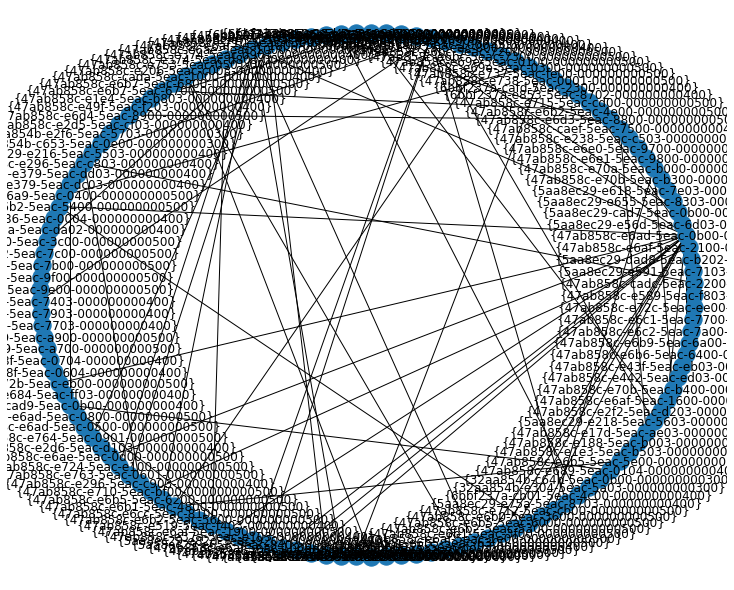

In [81]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

### Testing sklearn

In [143]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading

from sklearn.metrics import confusion_matrix, classification_report

In [146]:
df_label['LS_Binary'] = False
df_label['LS_Binary'].loc[(df_label['ProcessGuid']=='{47ab858c-e23d-5eac-c603-000000000400}')] = True

# Malicious Processes and outside the single ProcessGuid
X = df_label.loc[(df_label.ProcessGuid.notna()) & (df_label['THE_Binary']==True) & (df_label['LS_Binary']==False)].head(100)

# Malicious Processes inside the single
X = X.append(df_label.loc[(df_label['THE_Binary']==True) & (df_label['LS_Binary']==True)].head(100), sort=False)
#X = X.append(df_label.loc[(df_label['LS_Binary']==True) & (df_label['THE_Binary']==False)].head(100), sort=False)

# Benign Processes
X = X.append(df_label.loc[(df_label.ProcessGuid.notna()) & (df_label['THE_Binary']==False) & (df_label['LS_Binary']==False)].head(100), sort=False)
X.shape

(300, 547)

In [147]:
y_train = X['LS_Binary']
y_train = y_train.reset_index(drop=True)

y_test = X['THE_Binary']
y_test = y_test.reset_index(drop=True)

X = X[['ProcessGuid', 'ParentProcessGuid']]
X_train = pd.get_dummies(data=X, columns=['ProcessGuid', 'ParentProcessGuid'])
X_train = X_train.reset_index(drop=True)

In [148]:
X_train.shape

(300, 94)

In [149]:
y_train.value_counts()

False    200
True     100
Name: LS_Binary, dtype: int64

In [150]:
y_test.value_counts()

True     200
False    100
Name: THE_Binary, dtype: int64

In [152]:
X['ProcessGuid'].value_counts()

{47ab858c-e23d-5eac-c603-000000000400}    100
{47ab858c-e374-5eac-d803-000000000400}     82
{5aa8ec29-e5e4-5eac-7a03-000000000400}      4
{47ab858c-e689-5eac-0104-000000000400}      3
{5aa8ec29-e599-5eac-7403-000000000400}      3
                                         ... 
{47ab858c-e374-5eac-d903-000000000400}      1
{47ab858c-e6af-5eac-2300-000000000500}      1
{47ab858c-e721-5eac-db00-000000000500}      1
{5aa8ec29-daef-5eac-cd02-000000000400}      1
{47ab858c-e6e1-5eac-9800-000000000500}      1
Name: ProcessGuid, Length: 94, dtype: int64

In [153]:
# First try with THE_Binary subset. Kernel Crash. 
#    -> Trying smaller subset PoC .head(100)
lp_model = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X_train, y_train)

LabelSpreading(alpha=0.2, gamma=0.25, kernel='rbf', max_iter=20, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [154]:
lp_model.transduction_.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [155]:
np.unique(lp_model.transduction_, return_counts=True)

(array([False,  True]), array([200, 100]))

In [156]:
lp_model.classes_

array([False,  True])

In [130]:
X['ProcessGuid'].value_counts()

{47ab858c-e23d-5eac-c603-000000000400}    100
{47ab858c-e374-5eac-d803-000000000400}     82
{5aa8ec29-e5e4-5eac-7a03-000000000400}      4
{47ab858c-e1e4-5eac-b803-000000000400}      2
{47ab858c-e1f8-5eac-bc03-000000000400}      2
{47ab858c-e14e-5eac-ac03-000000000400}      2
{5aa8ec29-cad1-5eac-0100-000000000400}      2
{5aa8ec29-e5b7-5eac-7703-000000000400}      1
{5aa8ec29-e624-5eac-7f03-000000000400}      1
{47ab858c-e18b-5eac-b103-000000000400}      1
{47ab858c-e13c-5eac-a903-000000000400}      1
{5aa8ec29-e5b8-5eac-7903-000000000400}      1
{5aa8ec29-e56d-5eac-6e03-000000000400}      1
Name: ProcessGuid, dtype: int64

In [100]:
df_label.loc[df_label['THE_Binary'] == True]['ProcessGuid'].value_counts()

{47ab858c-e374-5eac-d803-000000000400}    15802
{47ab858c-e23d-5eac-c603-000000000400}     1670
{5aa8ec29-e5e4-5eac-7a03-000000000400}     1222
{47ab858c-e14e-5eac-ac03-000000000400}     1167
{47ab858c-e18b-5eac-b103-000000000400}      530
{47ab858c-e1f8-5eac-bc03-000000000400}      529
{5aa8ec29-e5b8-5eac-7903-000000000400}      431
{47ab858c-e1e4-5eac-b803-000000000400}      400
{5aa8ec29-cad1-5eac-0100-000000000400}      100
{47ab858c-e13c-5eac-a903-000000000400}       92
{47ab858c-e1e3-5eac-b603-000000000400}       84
{47ab858c-e188-5eac-b003-000000000400}       74
{47ab858c-e49f-5eac-f003-000000000400}       55
{47ab858c-e442-5eac-ed03-000000000400}       55
{47ab858c-e49e-5eac-ef03-000000000400}       55
{47ab858c-e49f-5eac-f103-000000000400}       55
{47ab858c-e442-5eac-ec03-000000000400}       55
{47ab858c-cad9-5eac-0b00-000000000400}       52
{5aa8ec29-e5b7-5eac-7703-000000000400}       46
{47ab858c-e2ac-5eac-cb03-000000000400}       45
{5aa8ec29-e624-5eac-7f03-000000000400}  

In [83]:
indices = np.arange(len(X_train))
rng = np.random.RandomState(2)
rng.shuffle(indices)

In [ ]:
# First try with THE_Binary subset. Kernel Crash. 
#    -> Trying smaller subset PoC .head(100)
lp_model = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X_train, y_train)

In [202]:
colName = 'ProcessGuid'
label = 'TP_Binary'

In [219]:

X = pd.get_dummies(df_label[colName].loc[df_label[label]==True])
#X = X.reindex(len(X))
X = X.reset_index(drop=True)
y = df_label[label].loc[df_label[label]==True]
#y = y.reindex(len(y))
y = y.reset_index(drop=True)
#X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)
X

,{47ab858c-cad9-5eac-0b00-000000000400},{47ab858c-cc06-5eac-9402-000000000400},{47ab858c-e13c-5eac-a903-000000000400},{47ab858c-e144-5eac-ab03-000000000400},{47ab858c-e14e-5eac-ac03-000000000400},{47ab858c-e188-5eac-b003-000000000400},{47ab858c-e18b-5eac-b103-000000000400},{47ab858c-e1e3-5eac-b603-000000000400},{47ab858c-e1e4-5eac-b803-000000000400},{47ab858c-e1f8-5eac-bc03-000000000400},{47ab858c-e23d-5eac-c603-000000000400},{47ab858c-e2ac-5eac-cb03-000000000400},{47ab858c-e2f2-5eac-d203-000000000400},{47ab858c-e305-5eac-d303-000000000400},{47ab858c-e342-5eac-d703-000000000400},{47ab858c-e374-5eac-d803-000000000400},{47ab858c-e442-5eac-ec03-000000000400},{47ab858c-e442-5eac-ed03-000000000400},{47ab858c-e49e-5eac-ef03-000000000400},{47ab858c-e49f-5eac-f003-000000000400},{47ab858c-e49f-5eac-f103-000000000400},{47ab858c-e6b2-5eac-4d00-000000000500},{5aa8ec29-cad1-5eac-0100-000000000400},{5aa8ec29-e4ec-5eac-6803-000000000400},{5aa8ec29-e52e-5eac-6b03-000000000400},{5aa8ec29-e56d-5eac-6e03-000000000400},{5aa8ec29-e5b7-5eac-7703-000000000400},{5aa8ec29-e5b8-5eac-7903-000000000400},{5aa8ec29-e5e4-5eac-7a03-000000000400},{5aa8ec29-e603-5eac-7b03-000000000400},{5aa8ec29-e618-5eac-7e03-000000000400},{5aa8ec29-e624-5eac-7f03-000000000400},{5aa8ec29-e63e-5eac-8203-000000000400},{5aa8ec29-e655-5eac-8303-000000000400}
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [220]:
y

0       True
1       True
2       True
3       True
4       True
        ... 
3459    True
3460    True
3461    True
3462    True
3463    True
Name: TP_Binary, Length: 3464, dtype: bool

In [221]:
indices = np.arange(len(X))
rng = np.random.RandomState(2)
rng.shuffle(indices)

In [222]:
#X = digits.data[indices[:340]]
#y = digits.target[indices[:340]]
#images = digits.images[indices[:340]]

n_total_samples = len(y)
n_labeled_points = 40

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

In [223]:
# #############################################################################
# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1

In [224]:
# #############################################################################
# Learn with LabelSpreading
# First Run Error: MemoryError MemoryError: Unable to allocate 301. GiB for an array with shape (200900, 200900) and data type float64
#    Changing to TP_Binary==True subset
# Second Run Error: KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'
lp_model = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

In [225]:
cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

Label Spreading model: 40 labeled & 3424 unlabeled points (3464 total)
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      3424

    accuracy                           1.00      3424
   macro avg       1.00      1.00      1.00      3424
weighted avg       1.00      1.00      1.00      3424

Confusion matrix
[[3424]]


In [ ]:
# issue with my data subset and label. Picked subset with all True label. Not surprising result.
#     maybe start with a new label. LS_Binary?
#     pick one process guid to label malicious -> see if it props to other malicious process guids

### Testing scikit-multilearn

In [89]:
from skmultilearn.dataset import load_dataset

In [90]:
X_train, y_train, feature_names, label_names = load_dataset('emotions', 'train')
X_test, y_test, _, _ = load_dataset('emotions', 'test')

emotions:train - exists, not redownloading
emotions:test - exists, not redownloading


In [91]:
feature_names[:10]

[('Mean_Acc1298_Mean_Mem40_Centroid', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Rolloff', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_Flux', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_0', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_1', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_2', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_3', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_4', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_5', 'NUMERIC'),
 ('Mean_Acc1298_Mean_Mem40_MFCC_6', 'NUMERIC')]

In [92]:
label_names

[('amazed-suprised', ['0', '1']),
 ('happy-pleased', ['0', '1']),
 ('relaxing-calm', ['0', '1']),
 ('quiet-still', ['0', '1']),
 ('sad-lonely', ['0', '1']),
 ('angry-aggresive', ['0', '1'])]

In [93]:
X_train

<391x72 sparse matrix of type '<class 'numpy.float64'>'
	with 28059 stored elements in List of Lists format>

In [94]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

In [95]:
clf = BinaryRelevance(
    classifier=SVC(),
    require_dense=[False, True]
)

In [96]:
clf.fit(X_train, y_train)

BinaryRelevance(classifier=SVC(), require_dense=[False, True])

In [97]:
clf.classifiers_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [98]:
prediction = clf.predict(X_test)

In [99]:
prediction

<202x6 sparse matrix of type '<class 'numpy.int64'>'
	with 27 stored elements in Compressed Sparse Column format>

In [100]:
import sklearn.metrics as metrics

In [101]:
metrics.hamming_loss(y_test, prediction)

0.3250825082508251

In [102]:
metrics.accuracy_score(y_test, prediction)

0.01485148514851485

In [103]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))
print(edge_map)

6 labels, 14 edges
{(1, 2): 58.0, (0, 5): 61.0, (1, 5): 6.0, (0, 1): 33.0, (2, 3): 66.0, (2, 4): 60.0, (3, 4): 56.0, (4, 5): 9.0, (2, 5): 5.0, (0, 4): 4.0, (1, 4): 1.0, (0, 2): 9.0, (1, 3): 6.0, (3, 5): 2.0}


In [104]:
from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

partition = clusterer.fit_predict(X_train,y_train)
partition

array([[0, 1, 5],
       [2, 3, 4]])

In [105]:
membership_vector = to_membership_vector(partition)

/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


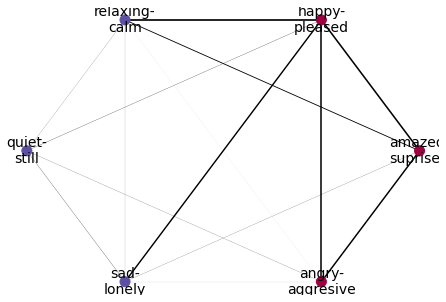

In [107]:
import networkx as nx
names_dict = dict(enumerate(x[0].replace('-','-\n') for x in label_names))

import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=100,
    font_size=14
)

### Testing Beagle

In [180]:
X = df_label.loc[(df_label['EventID']==1)].head(100)

In [181]:
X.shape

(100, 546)

In [182]:
# remove null only columns
X = X[X.columns[~X.isnull().all()]]

In [183]:
X.shape

(100, 58)

In [184]:
from beagle.backends import NetworkX
#from beagle.datasources import JSONData
#from beagle.datasources.json_data import JSONFile
from beagle.transformers import SysmonTransformer

In [185]:
import os
import json
from typing import Dict, Generator, List

from beagle.datasources.base_datasource import DataSource
from beagle.transformers import GenericTransformer

class JSONData(DataSource):
    """A generic data source which returns events one by one
    """

    name = "JSON Data"
    transformers = [GenericTransformer]
    category = "Generic Data"

    def __init__(self, events: List[Dict]) -> None:
        self._events = events

    def events(self) -> Generator[dict, None, None]:
        for event in self._events:
            yield event

    def metadata(self) -> dict:
        return {}

In [186]:
JSONData(X.to_json())

In [187]:
JSONData(X.head(1).to_dict('records'))

In [188]:
datasource = JSONData(X.head(1).to_dict('records'))

In [189]:
transformer = SysmonTransformer(datasource=datasource)

2020-07-01T02:20:22 | beagle.transformers.sysmon_transformer.__init__:29 | INFO | Created Sysmon Transformer.


In [190]:
nodes = transformer.run()

2020-07-01T02:20:23 | beagle.transformers.base_transformer._consumer_thread:143 | WARNING | Error when parsing event, recieved exception 'EventData_ParentImage'
2020-07-01T02:20:23 | beagle.transformers.base_transformer.run:111 | INFO | Finished processing of events, created 0 nodes.
2020-07-01T02:20:23 | beagle.transformers.base_transformer.run:114 | WARNING | Parsing finished with errors.


In [191]:
X['EventData_ParentImage'] = X['ParentImage']
X['EventData_ParentProcessId'] = X['ParentProcessId']
X['EventData_ParentProcessGuid'] = X['ParentProcessGuid']
X['EventData_Image'] = X['Image']
X['EventData_CommandLine'] = X['CommandLine']
X['EventData_Hashes'] = X['Hashes']

X['Computer'] = X['Hostname']
X['EventData_User'] = X['User']
X['EventData_UtcTime'] = X['UtcTime']

X['EventData_ProcessGuid'] = X['ProcessGuid']
X['EventData_ProcessId'] = X['ProcessId']

In [192]:
datasource = JSONData(X.head(1).to_dict('records'))
transformer = SysmonTransformer(datasource=datasource)
nodes = transformer.run()

2020-07-01T02:20:34 | beagle.transformers.sysmon_transformer.__init__:29 | INFO | Created Sysmon Transformer.
2020-07-01T02:20:34 | beagle.transformers.base_transformer.run:111 | INFO | Finished processing of events, created 4 nodes.


In [193]:
nodes

[(<SysMonProc> process_guid={47ab858c-cadc-5eac-2200-000000000400}),
 (<File> host=SCRANTON.dmevals.local full_path=C:\Windows\System32\svchost.exe),
 (<SysMonProc> process_guid={47ab858c-e589-5eac-f803-000000000400}),
 (<File> host=SCRANTON.dmevals.local full_path=C:\Windows\System32\taskhostw.exe)]

In [194]:
backend = NetworkX(nodes=nodes)

2020-07-01T02:25:11 | beagle.backends.networkx.__init__:51 | INFO | Initialized NetworkX Backend


In [195]:
G = backend.graph()

2020-07-01T02:25:24 | beagle.backends.networkx.graph:65 | INFO | Beginning graph generation.
2020-07-01T02:25:24 | beagle.backends.networkx.graph:71 | INFO | Completed graph generation.
2020-07-01T02:25:24 | beagle.backends.networkx.graph:72 | INFO | Graph contains 4 nodes and 3 edges.


/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jake/miniconda3/envs/py3msc/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


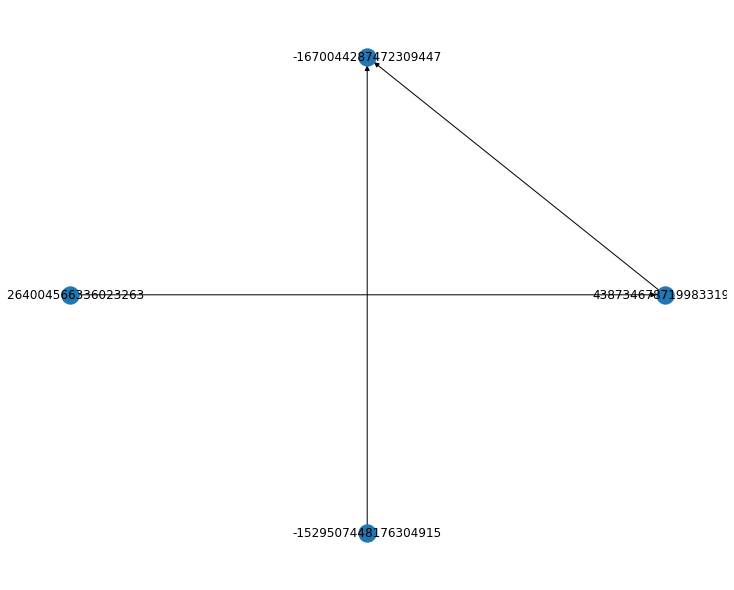

In [196]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [197]:
PrintG

# Key Evaluation

## Searching for Unique and high coverage keys

### File Keys

In [186]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    #display(df_label.loc[(df_label['THE_Binary'] == True)].groupby(['EventID', 'ParentCommandLine']).agg('count'))
    #display(df_label.groupby(['TP_Binary', 'EventID', 'NewSd']).agg('count'))
    display(df_label.loc[(df_label['TargetFilename'].notna())].groupby(['EventID']).agg('count'))

,@timestamp,@version,Category,Channel,EventReceivedTime,EventTime,EventType,ExecutionProcessID,Hostname,IpAddress,IpPort,Keywords,LogonGuid,Message,Opcode,OpcodeValue,ProviderGuid,RecordNumber,ServiceName,ServiceSid,Severity,SeverityValue,SourceModuleName,SourceModuleType,SourceName,Status,TargetDomainName,TargetUserName,Task,ThreadID,TicketEncryptionType,TicketOptions,TransmittedServices,Version,host,port,tags,TP_Label,Action,ActivityID,CalloutKey,CalloutName,ChangeType,Conditions,FilterId,FilterKey,FilterName,FilterType,LayerId,LayerKey,LayerName,ProcessId,ProviderKey,ProviderName,UserName,UserSid,Weight,AccessList,AccessMask,AccessReason,HandleId,ObjectName,ObjectServer,ObjectType,PrivilegeList,ProcessName,ResourceAttributes,RestrictedSidCount,SubjectDomainName,SubjectLogonId,SubjectUserName,SubjectUserSid,TransactionId,ShareLocalPath,ShareName,RelativeTargetName,CommandLine,MandatoryLabel,NewProcessId,NewProcessName,ParentProcessName,TargetLogonId,TargetUserSid,TokenElevationType,Service,DisabledPrivilegeList,EnabledPrivilegeList,CallerProcessId,CallerProcessName,TargetSid,AuthenticationPackageName,ElevatedToken,ImpersonationLevel,KeyLength,LmPackageName,LogonProcessName,LogonType,RestrictedAdminMode,TargetLinkedLogonId,TargetOutboundDomainName,TargetOutboundUserName,VirtualAccount,WorkstationName,SourceHandleId,SourceProcessId,TargetHandleId,TargetProcessId,AccountName,AccountType,ContextInfo,Domain,Payload,UserID,NewThreadId,RuleName,SourceImage,SourceProcessGuid,StartAddress,StartFunction,StartModule,TargetImage,TargetProcessGuid,UtcTime,MessageNumber,MessageTotal,Path,ScriptBlockId,ScriptBlockText,AlgorithmName,KeyName,KeyType,Operation,ReturnCode,Archived,Hashes,Image,IsExecutable,ProcessGuid,TargetFilename,User,CreationUtcTime,Company,Description,FileVersion,ImageLoaded,OriginalFileName,Product,Signature,SignatureStatus,Signed,DestinationHostname,DestinationIp,DestinationIsIpv6,DestinationPort,DestinationPortName,Initiated,Protocol,SourceHostname,SourceIp,SourceIsIpv6,SourcePort,SourcePortName,NewSd,OldSd,PipeName,CurrentDirectory,IntegrityLevel,LogonId,ParentCommandLine,ParentImage,ParentProcessGuid,ParentProcessId,TerminalSessionId,CallTrace,GrantedAccess,SourceProcessGUID,SourceThreadId,TargetProcessGUID,Device,TargetObject,Details,Application,FilterRTID,LayerRTID,SourceAddress,DestAddress,DestPort,Direction,RemoteMachineID,RemoteUserID,BootMenuPolicy,NewValue,NewValueType,ObjectValueName,OldValue,OldValueType,OperationType,ProfileUsed,RuleId,QueryName,QueryResults,QueryStatus,PreviousCreationUtcTime,EventCountTotal,EventIdx,GroupMembership,param1,Properties,Hash,PreAuthType,ClientProcessId,CountOfCredentialsReturned,ProcessCreationTime,ReadOperation,TargetName,Type,CalloutId,CalloutType,CorruptionActionState,DeviceName,DriveName,Config,IsTestConfig,DirtyPages,HiveName,HiveNameLength,KeysUpdated,PackageName,Workstation,DeviceNameLength,DeviceTime,DeviceVersionMajor,DeviceVersionMinor,FinalStatus,UserData,ServiceAccount,ServiceFileName,ServiceStartType,ServiceType,param10,param11,param2,param3,param4,param5,param6,param7,param8,param9,SubLayerKey,SubLayerName,SubLayerType,Default SD String:,ClassId,ClassName,CompatibleIds,DeviceDescription,DeviceId,LocationInformation,VendorIds,TargetProcessName,SecurityPackageName,AdditionalInfo,AdditionalInfo2,ProviderType,RuleAttr,AdapterName,AdapterSuffixName,DnsServerList,ErrorCode,Ipaddress,Sent UpdateServer,TaskContentNew,TaskName,ActiveProfile,MiniportName,MiniportNameLen,GroupPolicyApplied,LogDroppedPacketsEnabled,LogSuccessfulConnectionsEnabled,MulticastFlowsEnabled,OperationMode,Profile,RemoteAdminEnabled,TargetInfo,TargetLogonGuid,TargetServerName,ClientCreationTime,TimeSource,ImagePath,StartType,ProfileChanged,BootType,LoadOptions,EntryCount,KeyFilePath,ProviderContextKey,ProviderContextName,ProviderContextType,DwordVal,InterfaceGuid,InterfaceName,NewProfile,OldProfile,InstanceId,MaxRunspaces,MinRunspaces,CurrentStratumNumber,TimeSourceRefId,ReasonForRejection,Active,E